# **Data Mining & Machine Learning 2022 Project**
## Group: UNIL_OMEGA 
### *Detecting the difficulty level of French texts* 
##### [to go back to the GitHub repository](https://github.com/mlstudent12/DMML2022_Omega)

<!--TABLE OF CONTENTS --> 
<details>
  <summary>📂Table of contents </summary>
  <ol>
    </li>
    <li><a href="#packages-import">Packages import</a></li>
    <li><a href="#loading-data">Loading the data</a></li>
    <li><a href="#preparing-data">Preparing the data</a></li>
    <li><a href="#methods">Methods to predict and evaluate the model</a></li>
    <li><a href="#creation-training">Creation and training of the model</a></li>
    <li><a href="#labelling">Labeling data with our trained model</a></li>
  </ol>
</details>


# The model that gave us the best accuracy on Kaggle 

## 1. Packages import


First we import and install some additionnal packages.
When running it, you will have an error. You will need to delete the two "!pip install" and then click "restart runtime" (under runtime). After this you can rerun the code from here. 

In [ ]:
# imporant packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from google.colab import files
import tensorflow as tf
from sklearn.model_selection import train_test_split
!pip install tensorflow_hub
!pip install tensorflow_text
import tensorflow_hub as hub
import tensorflow_text as text
from keras import backend as K

# visualisation of data
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. Loading the data

In [ ]:
df_training = pd.read_csv('https://raw.githubusercontent.com/mlstudent12/DMML2022_Omega/main/data/training_data.csv', index_col=0)
df_pred = pd.read_csv('https://raw.githubusercontent.com/mlstudent12/DMML2022_Omega/main/data/unlabelled_test_data.csv', index_col=0)

## 3. Preparing the data

Now, we change our label into numerical values because our model won't accept strings. Since there is ordinal logic on the notation of language complexity, we chose to use ordinal encoder. 

In [ ]:
language_level = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2' ]
ordinal = OrdinalEncoder(categories = [language_level])
ordinal.fit(df_training[['difficulty']])
df_training['difficulty'] = ordinal.transform(df_training[['difficulty']])

Here, we do the train, test split. We have done the choice to minimise test data in order to train our model on more data (for the kaggle submition, test_size=0.01). This increased our accuracy on Kaggle of 0.02.

Here we put 20% in order to have a nice confusion matrix.

In [ ]:
y = tf.keras.utils.to_categorical(df_training['difficulty'].values, num_classes=6)
X_train, X_test, y_train, y_test = train_test_split(df_training['sentence'], y, test_size=0.20)

We use preprocessor and encoder form the TensorFlow library. We chose multilingual because there is no special one for French. The preprocessor and the encoder convert plain text into the format expected from a BERT model. 

In [ ]:
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

## 4. Methods to predict and evaluate the model

In [ ]:
# method to calculate the f1-score
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
# source of this function
# https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

In [ ]:
# method to label unlabelled data
def predict_class(reviews):
  return [np.argmax(pred) for pred in model.predict(reviews)]

In [ ]:
# method to go from OrdinalEncoder format to string
def format_submit(df):
  df=df.drop(['sentence'], axis=1)
  df['difficulty'] = df['difficulty'].replace([0], 'A1')
  df['difficulty'] = df['difficulty'].replace([1], 'A2')
  df['difficulty'] = df['difficulty'].replace([2], 'B1')
  df['difficulty'] = df['difficulty'].replace([3], 'B2')
  df['difficulty'] = df['difficulty'].replace([4], 'C1')
  df['difficulty'] = df['difficulty'].replace([5], 'C2')
  return df

## 5. Creation and training of the model

Here we create our model. We use "dense" layers as there use fixed size input and output. 
The dropout parameter is used to prevent overfitting.

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(6, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Let's look at what the parameters of our model.

*   Epochs: we set the number of epochs to 20, this means the model will make 20 iterations. 
*   Earlystop_callback: is used to stop the model. It will stop it if during 3 epochs the model does not improve (patience parameter set to 3).
*   restore_best_weights = True: it means the model will keep the best iteration in terms of "val_loss".


*   Adam optimizer: there are many optimizers availible on the Keras library. We tried them and the one that gave us the best accuracy was always Adam. 
*   categorical_crossentropy: is a loss function used in classification problem when there are more than 3 classes.













In [ ]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None),
      tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None),
      get_f1

]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(X_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (X_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
120/120 [==============================] - 81s 445ms/step - loss: 1.5423 - accuracy: 0.3438 - precision: 0.6197 - recall: 0.0344 - get_f1: 0.0621 - val_loss: 1.2794 - val_accuracy: 0.5031 - val_precision: 0.7800 - val_recall: 0.0812 - val_get_f1: 0.1438
Epoch 2/20
120/120 [==============================] - 51s 425ms/step - loss: 1.2672 - accuracy: 0.4695 - precision: 0.6879 - recall: 0.1492 - get_f1: 0.2393 - val_loss: 1.1703 - val_accuracy: 0.5250 - val_precision: 0.7224 - val_recall: 0.1979 - val_get_f1: 0.3059
Epoch 3/20
120/120 [==============================] - 49s 411ms/step - loss: 1.1689 - accuracy: 0.5154 - precision: 0.6943 - recall: 0.2247 - get_f1: 0.3356 - val_loss: 1.1297 - val_accuracy: 0.5500 - val_precision: 0.7345 - val_recall: 0.2104 - val_get_f1: 0.3229
Epoch 4/20
120/120 [==============================] - 49s 412ms/step - loss: 1.1259 - accuracy: 0.5396 - precision: 0.6971 - recall: 0.2625 - get_f1: 0.3772 - val_loss: 1.0979 - val_accuracy: 0.5562 - val_

## 6. Labeling data with our trained model

At this point we make the prediction with the model we just trained and give labels to the unlabelled data.

In [ ]:
df_pred["difficulty"] = predict_class(df_pred["sentence"])

38/38 [==============================] - 12s 311ms/step


Now, we need to change our labels from numerical to stings in order to do our submission on Kaggle. We also droped the sentence row to have the same format as the "sample_data"

In [ ]:
format_submit(df_pred)



,difficulty
id,
0,C2
1,A2
2,B1
3,B1
4,C2
...,...
1195,B1
1196,B1
1197,C2


30/30 [==============================] - 10s 316ms/step


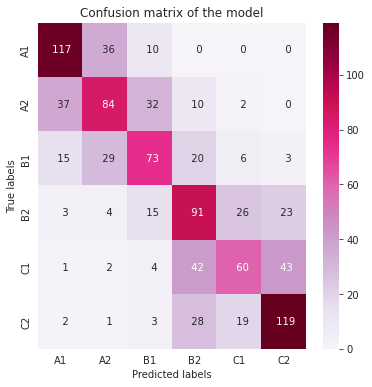

In [ ]:
y_pred = model.predict(X_test) 
y_pred_int = np.argmax(y_pred, axis=1)
y_test_int = np.argmax(y_test, axis=1) 
sns.set_style('whitegrid')
labels = list(unique_labels(y_test_int, y_pred_int))
cfm = confusion_matrix(y_test_int, y_pred_int, labels = labels)
fig, ax = plt.subplots(figsize=(6,6))
plt.title('Confusion matrix of the model')
sns.heatmap(cfm, annot=True, fmt='4g', cmap='PuRd', xticklabels=["A1","A2","B1","B2","C1","C2"], yticklabels=["A1","A2","B1","B2","C1","C2"])
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

Last step! Lets download our file and import it on Kaggle.

In [ ]:
df_pred.to_csv('output_submit.csv', encoding ='utf-8-sig',index=False) 
files.download('output_submit.csv')